In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.optimize import curve_fit
import warnings
warnings.filterwarnings('ignore')

# =============================================================================
# 1. CARGAR Y PREPARAR DATOS
# =============================================================================

# Cargar los archivos Excel
file_path = "Datos de Capstone.xlsx"  # 7V
file_path4 = "Datos de Capstone_4v.xlsx"
file_path10 = "Datos de Capstone_10v.xlsx"

df = pd.read_excel(file_path)
df4 = pd.read_excel(file_path4)
df10 = pd.read_excel(file_path10)

# Limpiar nombres de columnas
df.columns = df.columns.str.strip()
df4.columns = df4.columns.str.strip()
df10.columns = df10.columns.str.strip()

# Seleccionar columnas y filtrar datos
col1, col2 = df.columns[0], df.columns[1]
col11, col22 = df4.columns[0], df4.columns[1]
col111, col222 = df10.columns[0], df10.columns[1]

df_filtrado = df.dropna(subset=[col1, col2])
df4_filtrado = df4.dropna(subset=[col11, col22])
df10_filtrado = df10.dropna(subset=[col111, col222])

# Crear arrays
intensidad_relativa_7V = df_filtrado[col1].to_numpy()
angulo_7V = df_filtrado[col2].to_numpy()
intensidad_relativa_4V = df4_filtrado[col11].to_numpy()
angulo_4V = df4_filtrado[col22].to_numpy()
intensidad_relativa_10V = df10_filtrado[col111].to_numpy()
angulo_10V = df10_filtrado[col222].to_numpy()

In [2]:
# 2. PARÁMETROS EXPERIMENTALES Y CONSTANTES
# =============================================================================

# Constantes físicas
h = 6.626e-34  # Constante de Planck [J·s]
c = 3.0e8      # Velocidad de la luz [m/s]
k = 1.381e-23  # Constante de Boltzmann [J/K]

# Parámetros del tungsteno
rho_0 = 5.65e-8  # Resistividad a temperatura ambiente [Ω·m]
R_0 = 0.93       # Resistencia del filamento a temperatura ambiente [Ω]
R_holder = 0.1   # Resistencia del portalámparas [Ω] (valor típico)

# Valores reales medidos de voltaje y corriente
voltajes = {'4V': 4.0, '7V': 7.0, '10V': 10.0}
corrientes = {'4V': 0.41, '7V': 0.56, '10V': 0.68}  # [A] - VALORES REALES MEDIDOS

print("\nValores medidos:")
for key in voltajes:
    print(f"{key}: V = {voltajes[key]} V, I = {corrientes[key]} A")


Valores medidos:
4V: V = 4.0 V, I = 0.41 A
7V: V = 7.0 V, I = 0.56 A
10V: V = 10.0 V, I = 0.68 A


In [3]:
# 3. CÁLCULO DE TEMPERATURAS DEL FILAMENTO
# =============================================================================

def calcular_temperatura(V, I):
    """
    Calcula la temperatura del filamento usando las ecuaciones A1 y A2
    """
    # Ecuación A1: ρ = ρ₀(V/I - R_holder)/R₀
    R_meas = V / I
    rho = rho_0 * (R_meas - R_holder) / R_0
    
    # Convertir ρ a unidades de 10⁻⁸ Ω·m para la ecuación A2
    rho_units = rho / 1e-8
    
    # Ecuación A2: T(K) = 103 + 38.1ρ - 0.095ρ² + 0.000248ρ³
    T = 103 + 38.1 * rho_units - 0.095 * rho_units**2 + 0.000248 * rho_units**3
    
    return T, R_meas

# Calcular temperaturas para cada voltaje
temperaturas = {}
resistencias = {}

print("\nCálculo de temperaturas:")
for voltaje_key, V in voltajes.items():
    I = corrientes[voltaje_key]
    T, R = calcular_temperatura(V, I)
    temperaturas[voltaje_key] = T
    resistencias[voltaje_key] = R
    print(f"{voltaje_key}: R = {R:.2f} Ω, T = {T:.0f} K")


Cálculo de temperaturas:
4V: R = 9.76 Ω, T = 2061 K
7V: R = 12.50 Ω, T = 2540 K
10V: R = 14.71 Ω, T = 2909 K


In [4]:
# 4. ENCONTRAR EL PICO CENTRAL (ÁNGULO INICIAL)
# =============================================================================

def encontrar_pico_central(angulo, intensidad, voltaje_key):
    """
    Encuentra el pico central (luz blanca no desviada)
    """
    # Buscar picos prominentes
    peaks, properties = find_peaks(intensidad, height=0.3*max(intensidad), distance=30, prominence=0.1)
    
    if len(peaks) > 0:
        # Seleccionar el pico más alto
        idx_max = peaks[np.argmax(intensidad[peaks])]
        angulo_inicial = angulo[idx_max]
        print(f"{voltaje_key}: Pico central en {angulo_inicial:.2f}° (intensidad: {intensidad[idx_max]:.3f})")
        return angulo_inicial
    else:
        # Si no se encuentran picos, usar el máximo global
        idx_max = np.argmax(intensidad)
        angulo_inicial = angulo[idx_max]
        print(f"{voltaje_key}: Máximo global en {angulo_inicial:.2f}°")
        return angulo_inicial

In [5]:
# Encontrar ángulos iniciales para cada voltaje
print("\nDetección de picos centrales:")
angulo_inicial_4V = encontrar_pico_central(angulo_4V, intensidad_relativa_4V, "4V")
angulo_inicial_7V = encontrar_pico_central(angulo_7V, intensidad_relativa_7V, "7V")
angulo_inicial_10V = encontrar_pico_central(angulo_10V, intensidad_relativa_10V, "10V")



Detección de picos centrales:
4V: Pico central en 0.00° (intensidad: 5.450)
7V: Pico central en 91.75° (intensidad: 12.580)
10V: Pico central en 114.40° (intensidad: 21.920)


In [9]:
angulo_inicial_4V=87.10
angulo_inicial_7V=91.75
angulo_inicial_10V=114.40

In [10]:
def calcular_longitud_onda(angulo_verdadero, angulo_inicial):
    """
    Calcula la longitud de onda a partir del ángulo usando las ecuaciones A3 y A4
    """
    # Ángulo corregido (A3)
    ang_verd_corr = angulo_inicial - angulo_verdadero
    
    # Índice de refracción (A3)
    n = np.sqrt((2 * np.sin(np.radians(ang_verd_corr)) / np.sqrt(3) + 0.5) / 2 + 3/4)
    
    # Longitud de onda calculada (A4)
    denom = n - 1.635
    # Evitar división por cero
    denom = np.where(np.abs(denom) < 1e-10, 1e-10, denom)
    
    lambda_cal = 320 + 1/denom + 0.2/denom**2 + 0.19/denom**3
    
    # Filtrar entre 400 nm y 2500 nm
    lambda_filtrada = np.where((lambda_cal >= 400) & (lambda_cal <= 2500), lambda_cal, np.nan)
    
    return lambda_filtrada, n

# Calcular longitudes de onda para cada voltaje
print("\nCalculando longitudes de onda...")
lambda_4V, n_4V = calcular_longitud_onda(angulo_4V, angulo_inicial_4V)
lambda_7V, n_7V = calcular_longitud_onda(angulo_7V, angulo_inicial_7V)
lambda_10V, n_10V = calcular_longitud_onda(angulo_10V, angulo_inicial_10V)


Calculando longitudes de onda...


Datos cargados correctamente
4V: 2523 puntos
7V: 806 puntos
10V: 1627 puntos

Valores medidos:
4V: V = 4.0 V, I = 0.41 A
7V: V = 7.0 V, I = 0.56 A
10V: V = 10.0 V, I = 0.68 A

Cálculo de temperaturas:
4V: R = 9.76 Ω, T = 2061 K
7V: R = 12.50 Ω, T = 2540 K
10V: R = 14.71 Ω, T = 2909 K

DETECCIÓN MEJORADA DE PICOS CENTRALES

Buscando pico central para 4V...
Picos encontrados: 1
  Pico 0: ángulo = 87.10°, intensidad = 4.820
✓ 4V: Pico central seleccionado en 87.10° (intensidad: 4.820)

Buscando pico central para 7V...
Picos encontrados: 1
  Pico 0: ángulo = 91.75°, intensidad = 12.580
✓ 7V: Pico central seleccionado en 91.75° (intensidad: 12.580)

Buscando pico central para 10V...
Picos encontrados: 1
  Pico 0: ángulo = 114.40°, intensidad = 21.920
✓ 10V: Pico central seleccionado en 114.40° (intensidad: 21.920)


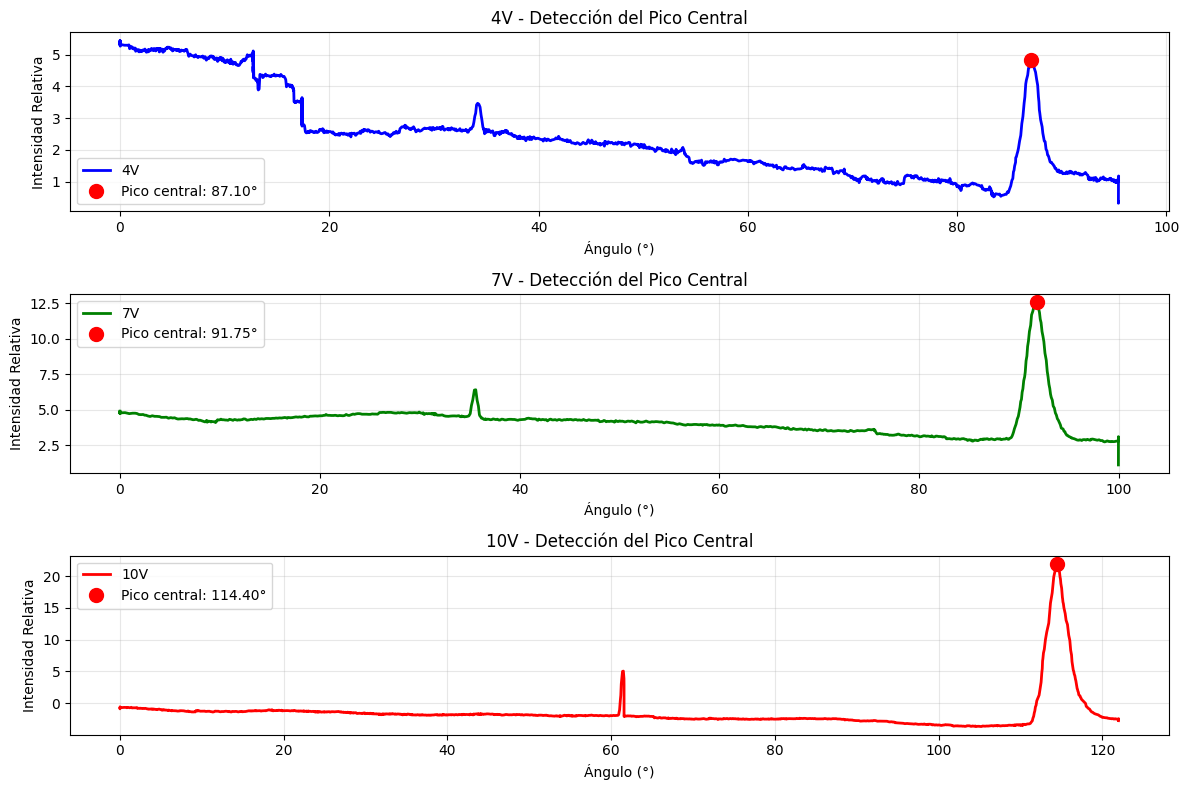


INSTRUCCIONES PARA CORRECCIÓN MANUAL
Si algún pico no fue detectado correctamente:
1. Mira las gráficas anteriores para verificar
2. Si necesitas corregir manualmente, usa estas líneas:

# Para corregir manualmente el pico del 4V:
# angulo_inicial_4V = [valor_correcto]  # Reemplaza con el ángulo correcto
# idx_pico_4V = np.argmin(np.abs(angulo_4V - angulo_inicial_4V))

# Para corregir manualmente el pico del 7V:
# angulo_inicial_7V = [valor_correcto]  # Reemplaza con el ángulo correcto
# idx_pico_7V = np.argmin(np.abs(angulo_7V - angulo_inicial_7V))

# Para corregir manualmente el pico del 10V:
# angulo_inicial_10V = [valor_correcto]  # Reemplaza con el ángulo correcto
# idx_pico_10V = np.argmin(np.abs(angulo_10V - angulo_inicial_10V))

RESUMEN FINAL DE PICOS DETECTADOS
4V:  Pico central en 87.10°
7V:  Pico central en 91.75°
10V: Pico central en 114.40°


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.optimize import curve_fit
import warnings
warnings.filterwarnings('ignore')

# =============================================================================
# 1. CARGAR Y PREPARAR DATOS
# =============================================================================

# Cargar los archivos Excel
file_path = "Datos de Capstone.xlsx"  # 7V
file_path4 = "Datos de Capstone_4v.xlsx"
file_path10 = "Datos de Capstone_10v.xlsx"

df = pd.read_excel(file_path)
df4 = pd.read_excel(file_path4)
df10 = pd.read_excel(file_path10)

# Limpiar nombres de columnas
df.columns = df.columns.str.strip()
df4.columns = df4.columns.str.strip()
df10.columns = df10.columns.str.strip()

# Seleccionar columnas y filtrar datos
col1, col2 = df.columns[0], df.columns[1]
col11, col22 = df4.columns[0], df4.columns[1]
col111, col222 = df10.columns[0], df10.columns[1]

df_filtrado = df.dropna(subset=[col1, col2])
df4_filtrado = df4.dropna(subset=[col11, col22])
df10_filtrado = df10.dropna(subset=[col111, col222])

# Crear arrays
intensidad_relativa_7V = df_filtrado[col1].to_numpy()
angulo_7V = df_filtrado[col2].to_numpy()
intensidad_relativa_4V = df4_filtrado[col11].to_numpy()
angulo_4V = df4_filtrado[col22].to_numpy()
intensidad_relativa_10V = df10_filtrado[col111].to_numpy()
angulo_10V = df10_filtrado[col222].to_numpy()

print("Datos cargados correctamente")
print(f"4V: {len(intensidad_relativa_4V)} puntos")
print(f"7V: {len(intensidad_relativa_7V)} puntos")
print(f"10V: {len(intensidad_relativa_10V)} puntos")

# =============================================================================
# 2. PARÁMETROS EXPERIMENTALES Y CONSTANTES
# =============================================================================

# Constantes físicas
h = 6.626e-34  # Constante de Planck [J·s]
c = 3.0e8      # Velocidad de la luz [m/s]
k = 1.381e-23  # Constante de Boltzmann [J/K]

# Parámetros del tungsteno
rho_0 = 5.65e-8  # Resistividad a temperatura ambiente [Ω·m]
R_0 = 0.93       # Resistencia del filamento a temperatura ambiente [Ω]
R_holder = 0.1   # Resistencia del portalámparas [Ω] (valor típico)

# Valores reales medidos de voltaje y corriente
voltajes = {'4V': 4.0, '7V': 7.0, '10V': 10.0}
corrientes = {'4V': 0.41, '7V': 0.56, '10V': 0.68}  # [A] - VALORES REALES MEDIDOS

print("\nValores medidos:")
for key in voltajes:
    print(f"{key}: V = {voltajes[key]} V, I = {corrientes[key]} A")

# =============================================================================
# 3. CÁLCULO DE TEMPERATURAS DEL FILAMENTO
# =============================================================================

def calcular_temperatura(V, I):
    """
    Calcula la temperatura del filamento usando las ecuaciones A1 y A2
    """
    # Ecuación A1: ρ = ρ₀(V/I - R_holder)/R₀
    R_meas = V / I
    rho = rho_0 * (R_meas - R_holder) / R_0
    
    # Convertir ρ a unidades de 10⁻⁸ Ω·m para la ecuación A2
    rho_units = rho / 1e-8
    
    # Ecuación A2: T(K) = 103 + 38.1ρ - 0.095ρ² + 0.000248ρ³
    T = 103 + 38.1 * rho_units - 0.095 * rho_units**2 + 0.000248 * rho_units**3
    
    return T, R_meas

# Calcular temperaturas para cada voltaje
temperaturas = {}
resistencias = {}

print("\nCálculo de temperaturas:")
for voltaje_key, V in voltajes.items():
    I = corrientes[voltaje_key]
    T, R = calcular_temperatura(V, I)
    temperaturas[voltaje_key] = T
    resistencias[voltaje_key] = R
    print(f"{voltaje_key}: R = {R:.2f} Ω, T = {T:.0f} K")

# =============================================================================
# 4. ENCONTRAR EL PICO CENTRAL (ÁNGULO INICIAL) - VERSIÓN MEJORADA
# =============================================================================

def encontrar_pico_central_mejorado(angulo, intensidad, voltaje_key, rango_esperado=(80, 115)):
    """
    Encuentra el pico central mejorado con criterios más estrictos
    """
    print(f"\nBuscando pico central para {voltaje_key}...")
    
    # Buscar picos con parámetros más estrictos
    peaks, properties = find_peaks(intensidad, 
                                  height=0.4*max(intensidad), 
                                  distance=20, 
                                  prominence=0.2*max(intensidad),
                                  width=5)
    
    print(f"Picos encontrados: {len(peaks)}")
    
    if len(peaks) > 0:
        # Filtrar picos que estén en el rango esperado
        picos_en_rango = []
        for i, peak in enumerate(peaks):
            if rango_esperado[0] <= angulo[peak] <= rango_esperado[1]:
                picos_en_rango.append(peak)
                print(f"  Pico {i}: ángulo = {angulo[peak]:.2f}°, intensidad = {intensidad[peak]:.3f}")
        
        if len(picos_en_rango) > 0:
            # Seleccionar el pico más alto dentro del rango esperado
            idx_max = picos_en_rango[np.argmax(intensidad[picos_en_rango])]
            angulo_inicial = angulo[idx_max]
            print(f"✓ {voltaje_key}: Pico central seleccionado en {angulo_inicial:.2f}° (intensidad: {intensidad[idx_max]:.3f})")
            return angulo_inicial, idx_max
        else:
            # Si no hay picos en el rango esperado, usar el máximo global en ese rango
            mask = (angulo >= rango_esperado[0]) & (angulo <= rango_esperado[1])
            if np.any(mask):
                idx_max = np.argmax(intensidad[mask])
                angulo_inicial = angulo[mask][idx_max]
                print(f"⚠ {voltaje_key}: Usando máximo en rango esperado: {angulo_inicial:.2f}°")
                return angulo_inicial, np.where(mask)[0][idx_max]
    
    # Fallback: usar el máximo global
    idx_max = np.argmax(intensidad)
    angulo_inicial = angulo[idx_max]
    print(f"⚠ {voltaje_key}: Usando máximo global: {angulo_inicial:.2f}°")
    return angulo_inicial, idx_max

# Encontrar ángulos iniciales para cada voltaje
print("\n" + "="*50)
print("DETECCIÓN MEJORADA DE PICOS CENTRALES")
print("="*50)

angulo_inicial_4V, idx_pico_4V = encontrar_pico_central_mejorado(angulo_4V, intensidad_relativa_4V, "4V")
angulo_inicial_7V, idx_pico_7V = encontrar_pico_central_mejorado(angulo_7V, intensidad_relativa_7V, "7V")
angulo_inicial_10V, idx_pico_10V = encontrar_pico_central_mejorado(angulo_10V, intensidad_relativa_10V, "10V")

# =============================================================================
# 5. VISUALIZACIÓN PARA VERIFICAR LOS PICOS DETECTADOS
# =============================================================================

plt.figure(figsize=(12, 8))

# Gráfica 4V
plt.subplot(3, 1, 1)
plt.plot(angulo_4V, intensidad_relativa_4V, 'b-', label='4V', linewidth=2)
plt.plot(angulo_4V[idx_pico_4V], intensidad_relativa_4V[idx_pico_4V], 'ro', 
         markersize=10, label=f'Pico central: {angulo_inicial_4V:.2f}°')
plt.xlabel('Ángulo (°)')
plt.ylabel('Intensidad Relativa')
plt.title('4V - Detección del Pico Central')
plt.legend()
plt.grid(True, alpha=0.3)

# Gráfica 7V
plt.subplot(3, 1, 2)
plt.plot(angulo_7V, intensidad_relativa_7V, 'g-', label='7V', linewidth=2)
plt.plot(angulo_7V[idx_pico_7V], intensidad_relativa_7V[idx_pico_7V], 'ro', 
         markersize=10, label=f'Pico central: {angulo_inicial_7V:.2f}°')
plt.xlabel('Ángulo (°)')
plt.ylabel('Intensidad Relativa')
plt.title('7V - Detección del Pico Central')
plt.legend()
plt.grid(True, alpha=0.3)

# Gráfica 10V
plt.subplot(3, 1, 3)
plt.plot(angulo_10V, intensidad_relativa_10V, 'r-', label='10V', linewidth=2)
plt.plot(angulo_10V[idx_pico_10V], intensidad_relativa_10V[idx_pico_10V], 'ro', 
         markersize=10, label=f'Pico central: {angulo_inicial_10V:.2f}°')
plt.xlabel('Ángulo (°)')
plt.ylabel('Intensidad Relativa')
plt.title('10V - Detección del Pico Central')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# =============================================================================
# 6. CORRECCIÓN MANUAL SI ES NECESARIO
# =============================================================================

print("\n" + "="*50)
print("INSTRUCCIONES PARA CORRECCIÓN MANUAL")
print("="*50)
print("Si algún pico no fue detectado correctamente:")
print("1. Mira las gráficas anteriores para verificar")
print("2. Si necesitas corregir manualmente, usa estas líneas:")
print("")
print("# Para corregir manualmente el pico del 4V:")
print("# angulo_inicial_4V = [valor_correcto]  # Reemplaza con el ángulo correcto")
print("# idx_pico_4V = np.argmin(np.abs(angulo_4V - angulo_inicial_4V))")
print("")
print("# Para corregir manualmente el pico del 7V:")
print("# angulo_inicial_7V = [valor_correcto]  # Reemplaza con el ángulo correcto")
print("# idx_pico_7V = np.argmin(np.abs(angulo_7V - angulo_inicial_7V))")
print("")
print("# Para corregir manualmente el pico del 10V:")
print("# angulo_inicial_10V = [valor_correcto]  # Reemplaza con el ángulo correcto")
print("# idx_pico_10V = np.argmin(np.abs(angulo_10V - angulo_inicial_10V))")

# Resumen final
print("\n" + "="*50)
print("RESUMEN FINAL DE PICOS DETECTADOS")
print("="*50)
print(f"4V:  Pico central en {angulo_inicial_4V:.2f}°")
print(f"7V:  Pico central en {angulo_inicial_7V:.2f}°")
print(f"10V: Pico central en {angulo_inicial_10V:.2f}°")